In [4]:
using CairoMakie
using Oceananigans
using Statistics
using JLD2
using FFTW

LoadError: ArgumentError: Package FFTW not found in current path:
- Run `import Pkg; Pkg.add("FFTW")` to install the FFTW package.


In [2]:
@inline function ψterms(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    vfilename = "down_front.jld2"
    ufilename = "across_front.jld2"
    wfilename = "vertical.jld2"
    bfilename = "buoyancy.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"])[101:end-2], file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
    function ψᶜᶜᶜ(uᶠᶜᶜ, wᶜᶜᶠ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        aᶠᶜᶜ = cumsum(uᶠᶜᶜ .* Δzᵃᵃᶜ; dims=2)

        bᶜᶜᶠ = cumsum(wᶜᶜᶠ .* Δx; dims=1)
        aᶜᶜᶜ = (circshift(aᶠᶜᶜ, (-1, 0)) .+ aᶠᶜᶜ) / 2
        bᶜᶜᶜ = (bᶜᶜᶠ[:, 1:end-1] .+ bᶜᶜᶠ[:, 2:end]) ./ 2
        return -aᶜᶜᶜ .+ bᶜᶜᶜ
    end
    function ∂z(a)
        let a = -(circshift(a, (0, 1)) - a) ./ Δzᵃᵃᶜ
            a[:, 1] .= 0
            a
        end
    end
    function ∂x(a)
        (circshift(a, (-1, 0)) - circshift(a, (1, 0))) ./ 2Δx
    end
    ∇²(a) = ∂x(∂x(a)) + ∂z(∂z(a))
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    file = jldopen("$foldername/$filename")
    ufile = jldopen("$foldername/$ufilename")
    vfile = jldopen("$foldername/$vfilename")
    wfile = jldopen("$foldername/$wfilename")
    bfile = jldopen("$foldername/$bfilename")
    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    Δt = ts[2] - ts[1]
    v(i) = file["timeseries/v_dfm/$(frames[i])"][:, 1, :]
    u(i) = file["timeseries/u_dfm/$(frames[i])"][:, 1, :]
    w(i) = file["timeseries/w_dfm/$(frames[i])"][:, 1, :]
    b(i) = file["timeseries/b_dfm/$(frames[i])"][:, 1, :]
    Fx(i) = (let a=ufile["timeseries/uwFLUX/$(frames[i])"]; a[:, 1, 2:end] + a[:, 1, 1:end-1] end) / 2
    w′v′(i) = -cumsum((let a=vfile["timeseries/vwFLUX/$(frames[i])"]; a[:, 1, 2:end] + a[:, 1, 1:end-1] end) .* Δzᵃᵃᶜ / 2; dims=2)
    Fz(i) = wfile["timeseries/wwFLUX/$(frames[i])"][:, 1, :]
    w′b′(i) = -cumsum((let a=bfile["timeseries/bwFLUX/$(frames[i])"]; a[:, 1, 2:end] + a[:, 1, 1:end-1] end) .* Δzᵃᵃᶜ / 2; dims=2)
    ψ(i) = ψᶜᶜᶜ(u(i), w(i), xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
    J₁₁(i) = ∂z(sp.f * v(1)) .* ∂x(∂z(ψ(i)))
    J₁₂(i) = ∂x(sp.f * v(1)) .* ∂z(∂z(ψ(i)))
    J₂₁(i) = ∂z(b(1)) .* ∂x(∂x(ψ(i)))
    J₂₂(i) = ∂x(b(1)) .* ∂z(∂x(ψ(i)))
    ∂²ψ∂t²(i) = (ψ(i+1) + ψ(i-1) - 2ψ(i)) / Δt^2
    data = map(2:length(frames)-1) do i
       map([∇²(∂²ψ∂t²(i)), ∂z(∂z(sp.f^2 * ψ(i))), -J₁₁(i), J₁₂(i), J₂₁(i), -J₂₂(i), -sp.f*∂z(∂z(w′v′(i))), ∂x(∂z(w′b′(i)))]) do field
            sum((field * Δx .* Δzᵃᵃᶜ)[1:512, 33+12:end-12])
        end
    end
    # Non linear terms
    δJ₁₁(i) = ∂z(sp.f * (v(i)-v(1))) .* ∂x(∂z(ψ(i)))
    δJ₁₂(i) = ∂x(sp.f * (v(i)-v(1))) .* ∂z(∂z(ψ(i)))
    δJ₂₁(i) = ∂z(b(i)-b(1)) .* ∂x(∂x(ψ(i)))
    δJ₂₂(i) = ∂x(b(i)-b(1)) .* ∂z(∂x(ψ(i)))
    δatw₁(i) = ∂z(sp.f * ∂z(v(i)) - ∂x(b(i))) .* ∂x(ψ(i))
    δatw₂(i) = ∂x(sp.f * ∂z(v(i)) - ∂x(b(i))) .* ∂z(ψ(i))
    δ∂tFψ(i) = let a(i)=∂x(Fz(i)) - ∂z(Fx(i)); (a(i+1) - a(i)) / Δt end
    data_nl = map(2:length(frames)-1) do i
       map([-δJ₁₁(i), δJ₁₂(i), δJ₂₁(i), -δJ₂₂(i), -δatw₁(i), δatw₂(i), -δ∂tFψ(i)]) do field
            sum((field * Δx .* Δzᵃᵃᶜ)[1:512, 33+12:end-12])
        end
    end
    close(file)
    close(ufile)
    close(vfile)
    close(wfile)
    close(bfile)
    return (ts[2:end-1], [data[i][j] for j in 1:length(data[1]), i in 1:length(data)], [data_nl[i][j] for j in 1:length(data_nl[1]), i in 1:length(data_nl)])
end

ψterms (generic function with 1 method)

In [3]:
(ts, data, data_nl) = ψterms("Ro08Ri001Ek0A15_1")

([0.010000000000000675, 0.020000000000000684, 0.030000000000000693, 0.0400000000000007, 0.05000000000000071, 0.06000000000000072, 0.07000000000000073, 0.08000000000000074, 0.09000000000000075, 0.10000000000000075  …  44.5799999999995, 44.5899999999995, 44.5999999999995, 44.609999999999495, 44.61999999999949, 44.62999999999949, 44.63999999999949, 44.64999999999949, 44.659999999999485, 44.66999999999948], [-0.032139035707045356 -0.026693842214920518 … 0.0823526097086704 0.07338493068343765; 2.507566353494316e-6 1.8105302098449413e-6 … 0.0335801478184915 0.03416864034850399; … ; 3.530105335804371e-5 5.681157539573791e-5 … 0.0025365291027257784 0.0022309414233141305; -5.399128765140144e-6 -6.896660749204364e-6 … 0.015232806521177387 0.015494820252498423], [1.0210523254946781e-10 2.5852713810340887e-9 … 0.040319829047163046 0.040234827815222265; -1.9170573842159662e-10 -2.4846094910221787e-9 … -0.06705681519632808 -0.06678947352604339; … ; 7.598587260557401e-10 1.5309445613526603e-9 … 0.003

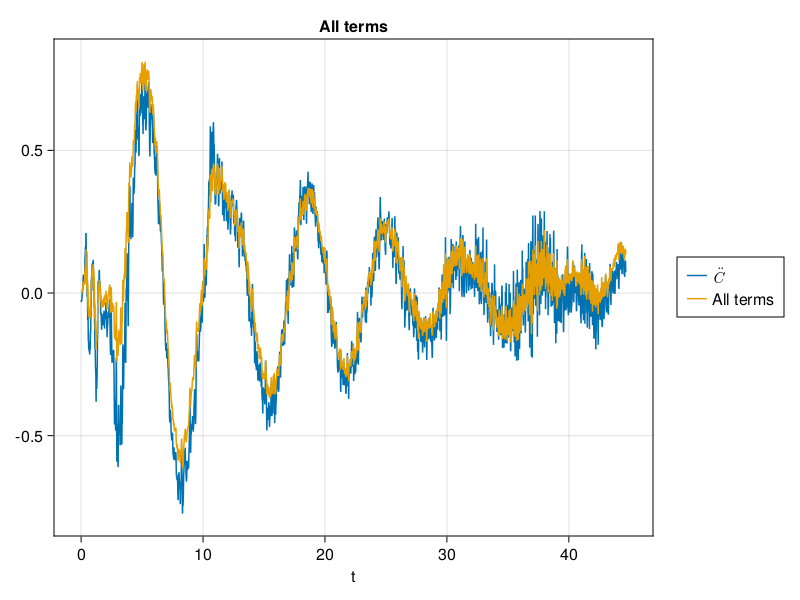

In [136]:
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", title="All terms")
ln1 = lines!(ax, ts, -data[1, :])
ln2 = lines!(ax, ts, sum(data[2:end, :]; dims=1)[1, :] .+ sum(data_nl; dims=1)[1, :])
Legend(fig[1, 2], [ln1, ln2], [L"\ddot{C}", "All terms"])
fig

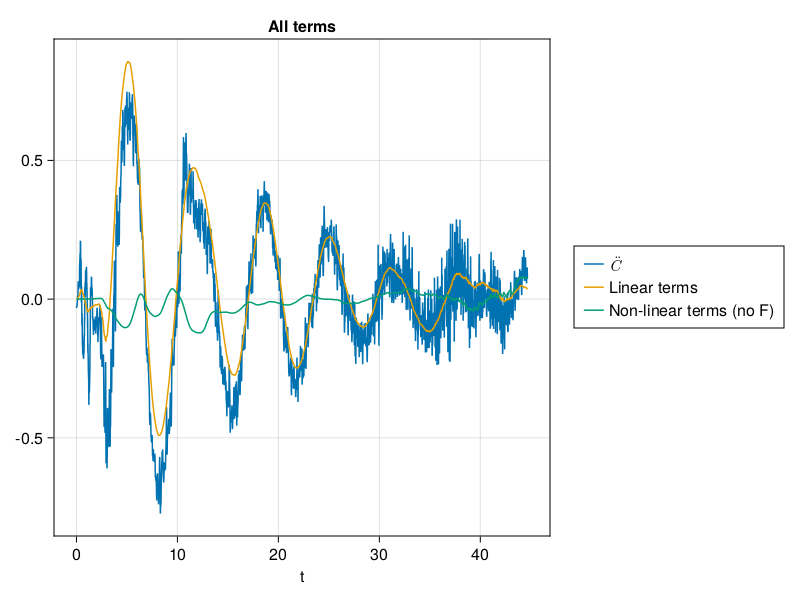

In [134]:
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", title="All terms")
ln1 = lines!(ax, ts, data[1, :])
ln2 = lines!(ax, ts, -sum(data[2:end, :]; dims=1)[1, :])
ln3 = lines!(ax, ts, -sum(data_nl[1:end-1, :]; dims=1)[1, :])
Legend(fig[1, 2], [ln1, ln2, ln3], [L"\ddot{C}", "Linear terms", "Non-linear terms (no F)"])
fig

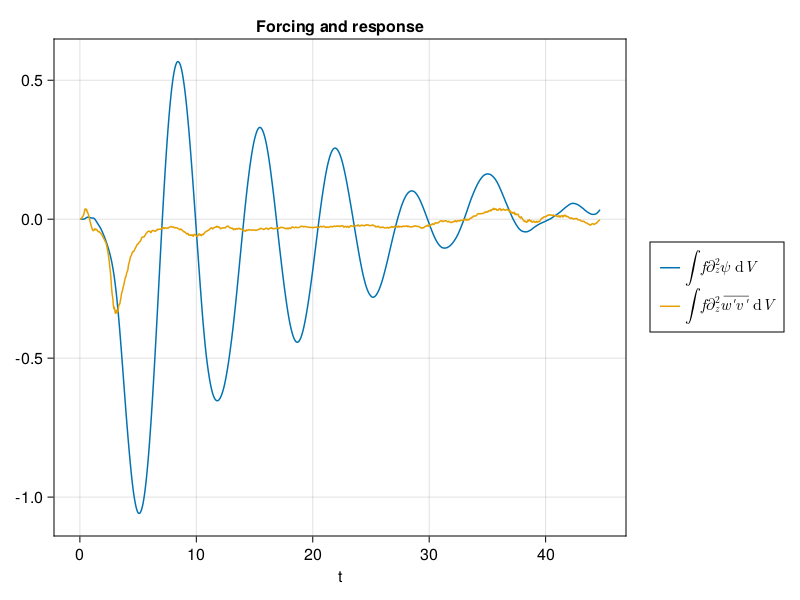

In [89]:
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", title="Forcing and response")
ln1 = lines!(ax, ts, data[2, :])
ln2 = lines!(ax, ts, -data[7, :])
Legend(fig[1, 2], [ln1, ln2], [L"\int f \partial_z^2 \psi\; \text{d}V", L"\int f \partial_z^2 \overline{w'v'}\; \text{d}V"])
fig

In [92]:
@inline function ψforcingresp(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    vfilename = "down_front.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"])[101:end-2], file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
    function ψᶜᶜᶜ(uᶠᶜᶜ, wᶜᶜᶠ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        aᶠᶜᶜ = cumsum(uᶠᶜᶜ .* Δzᵃᵃᶜ; dims=2)

        bᶜᶜᶠ = cumsum(wᶜᶜᶠ .* Δx; dims=1)
        aᶜᶜᶜ = (circshift(aᶠᶜᶜ, (-1, 0)) .+ aᶠᶜᶜ) / 2
        bᶜᶜᶜ = (bᶜᶜᶠ[:, 1:end-1] .+ bᶜᶜᶠ[:, 2:end]) ./ 2
        return -aᶜᶜᶜ .+ bᶜᶜᶜ
    end
    function ∂z(a)
        let a = -(circshift(a, (0, 1)) - a) ./ Δzᵃᵃᶜ
            a[:, 1] .= 0
            a
        end
    end
    function ∂x(a)
        (circshift(a, (-1, 0)) - circshift(a, (1, 0))) ./ 2Δx
    end
    ∇²(a) = ∂x(∂x(a)) + ∂z(∂z(a))
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    file = jldopen("$foldername/$filename")
    vfile = jldopen("$foldername/$vfilename")
    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    Δt = ts[2] - ts[1]
    v(i) = file["timeseries/v_dfm/$(frames[i])"][:, 1, :]
    u(i) = file["timeseries/u_dfm/$(frames[i])"][:, 1, :]
    w(i) = file["timeseries/w_dfm/$(frames[i])"][:, 1, :]
    w′v′(i) = -cumsum((let a=vfile["timeseries/vwFLUX/$(frames[i])"]; a[:, 1, 2:end] + a[:, 1, 1:end-1] end) .* Δzᵃᵃᶜ / 2; dims=2)
    ψ(i) = ψᶜᶜᶜ(u(i), w(i), xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
    ∂²ψ∂t²(i) = (ψ(i+1) + ψ(i-1) - 2ψ(i)) / Δt^2
    data = map(2:length(frames)-1) do i
       map([∂²ψ∂t²(i), sp.f^2 * ψ(i), -sp.f*w′v′(i)]) do field
            sum((field * Δx .* Δzᵃᵃᶜ)[1:512, 33+12:end-12])
        end
    end
    close(file)
    close(vfile)
    return (ts[2:end-1], [data[i][j] for j in 1:length(data[1]), i in 1:length(data)])
end

ψforcingresp (generic function with 1 method)

In [93]:
(_, data_forcing) = ψforcingresp("Ro08Ri001Ek0A15_1")

([0.010000000000000675, 0.020000000000000684, 0.030000000000000693, 0.0400000000000007, 0.05000000000000071, 0.06000000000000072, 0.07000000000000073, 0.08000000000000074, 0.09000000000000075, 0.10000000000000075  …  44.5799999999995, 44.5899999999995, 44.5999999999995, 44.609999999999495, 44.61999999999949, 44.62999999999949, 44.63999999999949, 44.64999999999949, 44.659999999999485, 44.66999999999948], [2.516196512438064e-5 2.10033488023642e-5 … -7.953923174346226e-5 -7.768266855980594e-5; 1.1108269387308011e-8 2.4732735287075628e-8 … -3.060490037710986e-5 -3.099654459818904e-5; -2.5083456699073824e-8 -5.539234361372954e-8 … -1.1584423145054665e-5 -1.1445994770639605e-5])

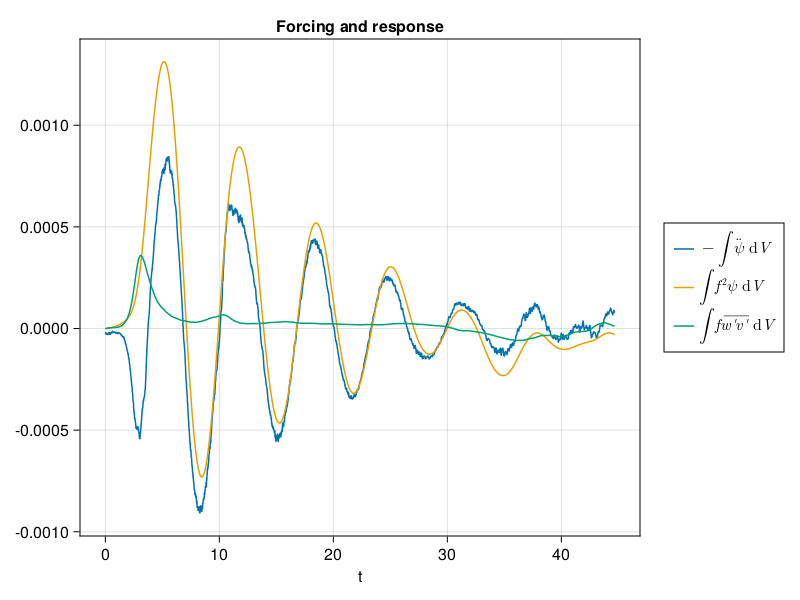

In [137]:
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", title="Forcing and response")
ln1 = lines!(ax, ts, -data_forcing[1, :])
ln2 = lines!(ax, ts, data_forcing[2, :])
ln3 = lines!(ax, ts, -data_forcing[3, :])
Legend(fig[1, 2], [ln1, ln2, ln3], [L"-\int  \ddot{\psi}\; \text{d}V", L"\int  f^2\psi\; \text{d}V", L"\int f \overline{w'v'}\; \text{d}V"])
fig